In [1]:
import json
import os 
import re
import ast
import copy
import joblib 

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.cluster import  KMeans
from sklearn import metrics
from sklearn.manifold import TSNE

import torch
from torch.nn import CrossEntropyLoss
from transformers import AutoModelForCausalLM
from datasets import load_dataset

from llmtuner.model import load_tokenizer
from llmtuner.hparams import get_train_args
from llmtuner.data import get_dataset

[2024-03-13 13:38:47,294] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
args = {
    "stage": "sft",
    "do_train": True,
    # "predict_with_generate": True,
    "template": "default",
    "model_name_or_path": "../models/roborock_control_lora_Yi_merged",
    # "cache_path": "/root/PycharmProjects/ChatGLM3/finetune_chatmodel_demo/formatted_data/hf_dataset/tool_alpaca.hf",
    "dataset": "roborock_control",
    "dataset_dir": "./",
    "cutoff_len": 2048,
    "finetuning_type": "lora",
    "lora_target": "all",
    "output_dir": "../outputs/roborock_control_lora_sfsfsf_merged2",
    # "adapter_name_or_path": "../models/roborock_control_lora_Yi/checkpoint-250",
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "per_device_train_batch_size": 4,
    "gradient_accumulation_steps": 4,
    "lr_scheduler_type": "cosine",
    "logging_steps": 10,
    "save_steps": 500,
    "learning_rate": 1e-3,
    "max_steps": 1000,
    "lora_rank": 32,
    "plot_loss": True,
    "fp16": True
}
model_args, data_args, training_args, finetuning_args, generating_args = get_train_args(args)

03/13/2024 13:38:51 - WARNING - llmtuner.hparams.parser - `ddp_find_unused_parameters` needs to be set as False for LoRA in DDP training.
03/13/2024 13:38:51 - INFO - llmtuner.hparams.parser - Process rank: 0, device: cuda:0, n_gpu: 8, distributed training: True, compute dtype: torch.float16


In [3]:
tokenizer = load_tokenizer(model_args)

[INFO|tokenization_utils_base.py:2025] 2024-03-13 13:38:52,499 >> loading file tokenizer.model
[INFO|tokenization_utils_base.py:2025] 2024-03-13 13:38:52,500 >> loading file added_tokens.json
[INFO|tokenization_utils_base.py:2025] 2024-03-13 13:38:52,500 >> loading file special_tokens_map.json
[INFO|tokenization_utils_base.py:2025] 2024-03-13 13:38:52,501 >> loading file tokenizer_config.json
[INFO|tokenization_utils_base.py:2025] 2024-03-13 13:38:52,501 >> loading file tokenizer.json


In [4]:
dataset = get_dataset(tokenizer, model_args, data_args, training_args, stage="sft")

03/13/2024 13:38:53 - INFO - llmtuner.data.loader - Loading dataset ToolAlpaca/data/formatted_data/robocontrol_dataset_sharegpt.json...
03/13/2024 13:38:53 - WARNING - llmtuner.data.utils - Checksum failed: missing SHA-1 hash value in dataset_info.json.
input_ids:
[3961, 726, 2328, 592, 567, 1926, 5177, 59601, 144, 59644, 22980, 10636, 59601, 2476, 59593, 10455, 144, 20256, 14750, 59601, 1117, 8904, 620, 1316, 631, 18267, 2476, 6992, 97, 7148, 5335, 2324, 631, 6980, 2942, 59594, 17631, 6992, 97, 705, 639, 620, 728, 4074, 12772, 592, 2594, 4577, 4210, 97, 705, 1804, 59594, 12166, 4577, 144, 20256, 2007, 2905, 59601, 144, 141, 59594, 2915, 662, 3471, 97, 3221, 4591, 59568, 97, 1206, 629, 853, 593, 1273, 5858, 97, 2421, 97, 25309, 97, 17936, 59651, 144, 141, 59594, 2942, 59593, 17631, 59593, 13957, 662, 3471, 4591, 2942, 59594, 17631, 4577, 4192, 594, 2942, 3351, 144, 144, 59644, 22980, 10636, 59601, 3288, 144, 20256, 14750, 59601, 967, 574, 12880, 562, 4577, 593, 663, 10630, 705, 911, 39

In [5]:
model = AutoModelForCausalLM.from_pretrained(model_args.model_name_or_path, trust_remote_code=True, output_hidden_states=True)

[INFO|configuration_utils.py:727] 2024-03-13 13:38:56,136 >> loading configuration file ../models/roborock_control_lora_Yi_merged/config.json
[INFO|configuration_utils.py:792] 2024-03-13 13:38:56,139 >> Model config LlamaConfig {
  "_name_or_path": "../models/roborock_control_lora_Yi_merged",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 4,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 5000000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 64000
}

[INFO|modeling_

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

[INFO|modeling_utils.py:4350] 2024-03-13 13:39:01,756 >> All model checkpoint weights were used when initializing LlamaForCausalLM.

[INFO|modeling_utils.py:4358] 2024-03-13 13:39:01,757 >> All the weights of LlamaForCausalLM were initialized from the model checkpoint at ../models/roborock_control_lora_Yi_merged.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LlamaForCausalLM for predictions without further training.
[INFO|configuration_utils.py:779] 2024-03-13 13:39:01,766 >> loading configuration file ../models/roborock_control_lora_Yi_merged/generation_config.json
[INFO|configuration_utils.py:826] 2024-03-13 13:39:01,768 >> Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "pad_token_id": 0
}



In [6]:
device = "cuda:0"
_ = model.half().to(device)
model = model.eval()

In [7]:
df = pd.DataFrame()

In [8]:
# conditional ppl
device = "cuda:0"
logging_interval = 10
output_embeddings = False
pooling_option = -1
sequence_dim = 1 #Yi 1, chatglm 0

all_perplexity = []
all_embeddings = []
for i in range(len(dataset)):
    if i % logging_interval == 0:
        print(i)
    
    input_ids = torch.tensor([dataset[i]['input_ids']]).to(device)
    attn_mask = torch.tensor([dataset[i]['attention_mask']]).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, 
                        attention_mask=attn_mask,
                        )

    if output_embeddings and ("hidden_states" in outputs.keys()):
        hidden_states = outputs["hidden_states"][-1]
        if pooling_option == -1:
            pooled_hidden_states = hidden_states.select(dim=sequence_dim, index=-1)
        else:
            pooled_hidden_states = hidden_states.mean(dim=sequence_dim)
        all_embeddings.append(pooled_hidden_states)

    lm_logits = outputs.logits
    labels = torch.tensor([dataset[i]['labels']]).to(device)

    # Shift so that tokens < n predict n
    shift_logits = lm_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
   
    # Flatten the tokens
    loss_fct = CrossEntropyLoss(ignore_index=-100, reduction="none")
    loss = loss_fct(shift_logits.transpose(1, 2), shift_labels)
    loss_mask = torch.where(labels == -100, 0, 1).to(device)
    shift_loss_mask = loss_mask[..., 1:].contiguous()
    perplexity = torch.exp(
        (loss * shift_loss_mask).sum(1) / shift_loss_mask.sum(1)
    )
    all_perplexity.append(perplexity.item())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [9]:
df['conditional_ppl'] = all_perplexity

In [10]:
# conditional_embeddings = torch.concat(all_embeddings, dim=0).to("cpu").numpy()

In [11]:
# marginal ppl
device = "cuda:0"
batch_size = 1
logging_interval = 10
content_key = "labels"
# start_tokens = [64790, 64792] # chatglm3
start_tokens = [tokenizer.bos_token_id] # Yi
output_embeddings = True
pooling_option = None
sequence_dim = 1 # Yi 1, chatglm 0

all_perplexity = []
all_embeddings = []
for i in range(len(dataset)):
    if i % logging_interval == 0:
        print(i)
    
    if start_tokens is not None:
        bos_tokens_tensor = torch.tensor([start_tokens] * batch_size)
        input_ids = torch.cat([bos_tokens_tensor, 
                               torch.tensor([[
                                   j for j in dataset[i][content_key] if j != -100
                               ]])], dim=1).to(device)
    else:
        input_ids = torch.tensor([dataset[i][content_key]]).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, 
                        )
    
    if output_embeddings and ("hidden_states" in outputs.keys()):
        hidden_states = outputs["hidden_states"][-1]
        if pooling_option == -1:
            pooled_hidden_states = hidden_states.select(dim=sequence_dim, index=-1)
        else:
            pooled_hidden_states = hidden_states.mean(dim=sequence_dim)
        all_embeddings.append(pooled_hidden_states)
    
    lm_logits = outputs.logits
    labels = input_ids
    if start_tokens is not None:
        labels[:, :len(start_tokens)] = -100

    # Shift so that tokens < n predict n
    shift_logits = lm_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
   
    # Flatten the tokens
    loss_fct = CrossEntropyLoss(ignore_index=-100, reduction="none")
    loss = loss_fct(shift_logits.transpose(1, 2), shift_labels)
    loss_mask = torch.where(labels == -100, 0, 1).to(device)
    shift_loss_mask = loss_mask[..., 1:].contiguous()
    perplexity = torch.exp(
        (loss * shift_loss_mask).sum(1) / shift_loss_mask.sum(1)
    )
    all_perplexity.append(perplexity.item())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [12]:
marginal_embeddings = torch.concat(all_embeddings, dim=0).to("cpu").numpy()

In [13]:
df['marginal_ppl'] = all_perplexity

2
3
4
5
6
7
8
9
10
11
12
13
14


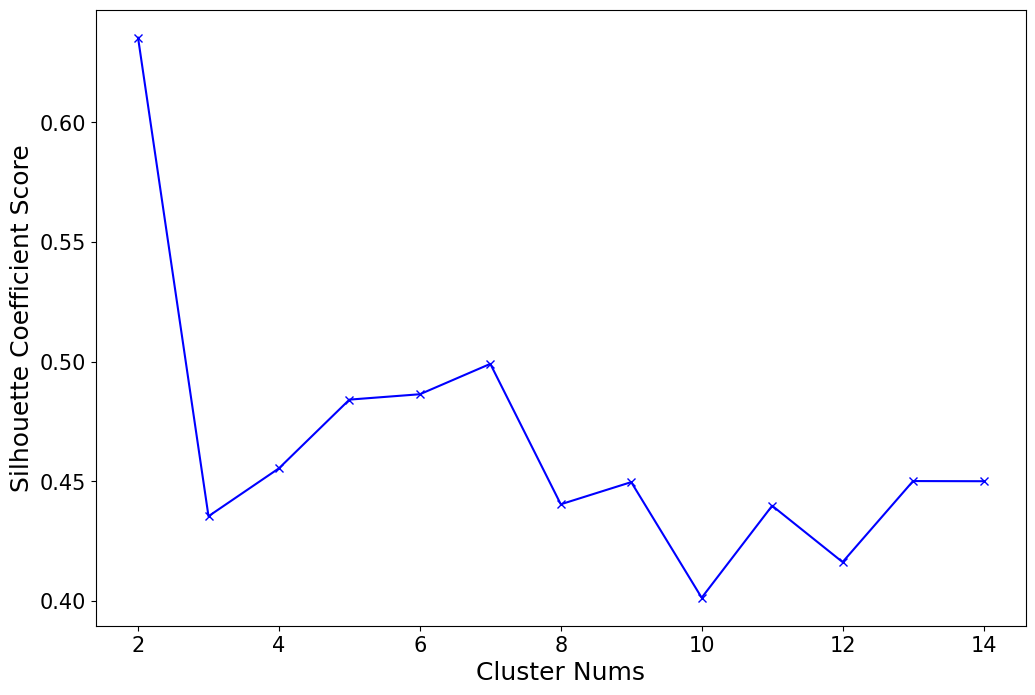

In [40]:
sc_scores = [] 
sse_list = [] 
clusters = range(2,15)
for k in clusters: 
    print(k)
    kmeans = KMeans(n_clusters=k) 
    kmeans_model = kmeans.fit(marginal_embeddings) 
    sc_score = metrics.silhouette_score(marginal_embeddings, kmeans_model.labels_, metric='euclidean')
    sc_scores.append(sc_score)
    sse_list.append(kmeans_model.inertia_) 
#作出K—平均轮廓系数曲线
plt.figure()
plt.plot(clusters, sc_scores, 'bx-')
plt.rcParams['figure.figsize'] = [12,8]
plt.xlabel('Cluster Nums',fontsize=18)
plt.ylabel('Silhouette Coefficient Score',fontsize=18)  #样本平均轮廓系数
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

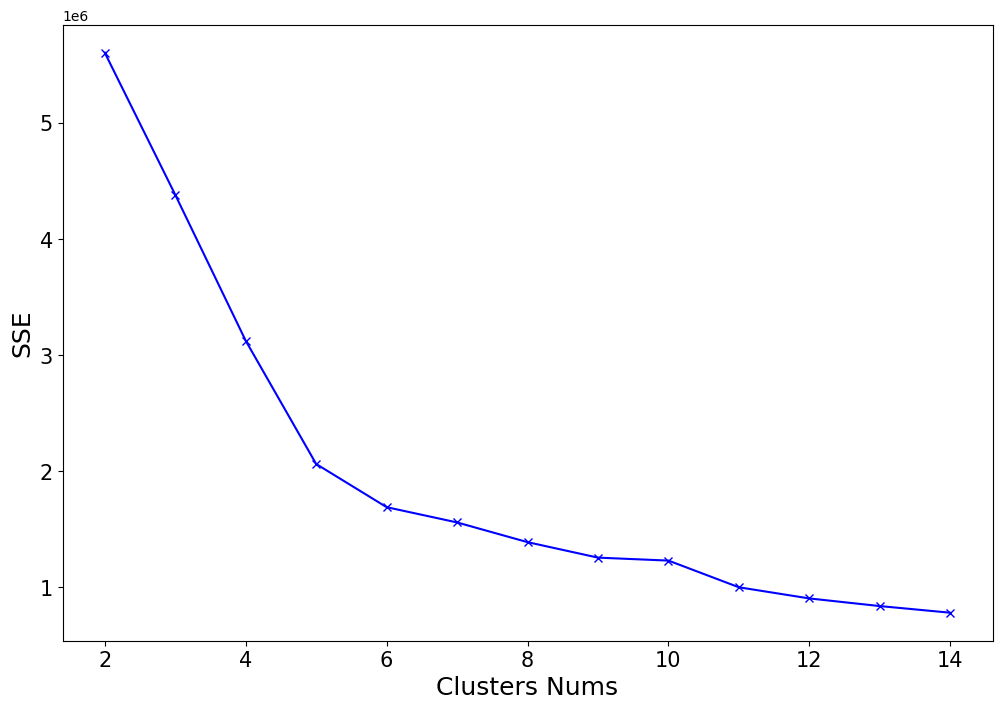

In [41]:
#折线图展示聚类数——SSE曲线
plt.figure() 
plt.plot(np.array(clusters), sse_list, 'bx-')
plt.rcParams['figure.figsize'] = [12,8]
plt.xlabel('Clusters Nums',fontsize=18)
plt.ylabel('SSE',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [14]:
kmeans = KMeans(n_clusters=6) 
kmeans_model = kmeans.fit(marginal_embeddings) 

In [15]:
df["cluster"] = kmeans_model.labels_

In [16]:
df["conditional_loss"] = df["conditional_ppl"].apply(lambda x: np.log(x))
df["marginal_loss"] = df["marginal_ppl"].apply(lambda x: np.log(x))
df["idf"] = df["conditional_loss"] / df["marginal_loss"]

In [17]:
num_clusters = len(np.unique(df["cluster"]))
# Get the indices for each cluster
cluster_indices = {i: np.where(df["cluster"] == i)[0] for i in range(num_clusters)}


In [18]:
def classify(confidence, low_th, up_th):
    result = np.array(["none"]*confidence.shape[0])
    for i in range(num_clusters):
        # Get the sorted indices for this cluster
        sorted_indices = cluster_indices[i]
    
        # Get the confidences for this cluster
        cluster_confidences = confidence[sorted_indices]
        lower_threshold = np.percentile(cluster_confidences, low_th)
        upper_threshold = np.percentile(cluster_confidences, up_th)
        print(lower_threshold, upper_threshold)
    
        # Get the indices of the samples within the middle level confidence range
        middle_indices = sorted_indices[(cluster_confidences >= lower_threshold) & (cluster_confidences <= upper_threshold)]
        low_indices = sorted_indices[(cluster_confidences < lower_threshold)]
        high_indices = sorted_indices[(cluster_confidences > upper_threshold)]
        result[middle_indices] = "middle"
        result[low_indices] = "low"
        result[high_indices] = "high"
    return result

In [20]:
low_th = 25
up_th = 75
df["idf_class"] = classify(df["idf"].values, low_th, up_th) 
df["conditional_ppl_class"] = classify(df["conditional_ppl"].values, low_th, up_th) 

0.00012180766070208642 0.001379060477642414
4.5349063384863915e-05 0.0003918286310273184
0.0002030035146849016 0.0024396336662194347
1.687917422869673e-05 0.00014687471411453627
1.185339703706416e-05 0.000665420041003978
4.508865827906277e-05 0.0019680888225032988
1.000410556793213 1.0048283338546753
1.0002473592758179 1.0020982027053833
1.0006033182144165 1.0073588490486145
1.0001131296157837 1.001351237297058
1.0000775754451752 1.0060918927192688
1.0002037286758423 1.0063912868499756


In [21]:
df.groupby(["cluster", "idf_class"]).agg(
    {"idf": [len, "mean", "min", "max"],
     "conditional_ppl": ["mean", "min", "max"]})

idf                               conditional_ppl  \
                   len      mean       min       max            mean   
cluster idf_class                                                      
0       high       286  0.008555  0.001380  0.085860        1.028148   
        low        286  0.000075  0.000027  0.000122        1.000239   
        midd       570  0.000438  0.000122  0.001375        1.001515   
1       high       169  0.005563  0.000392  0.058907        1.032853   
        low        169  0.000024  0.000011  0.000045        1.000131   
        midd       339  0.000161  0.000045  0.000392        1.000869   
2       high       183  0.011455  0.002446  0.087803        1.035322   
        low        183  0.000111  0.000034  0.000203        1.000353   
        midd       365  0.000739  0.000203  0.002433        1.002307   
3       high        67  0.003824  0.000149  0.071519        1.032527   
        low         67  0.000011  0.000007  0.000017        1.000073   
        midd       135  0.000069  0.000017  0.000147        1.000645   
4       high        39  0.012126  0.000788  0.064984        1.134564   
        low         39  0.000009  0.000007  0.000012        1.000058   
        midd        78  0.000096  0.000012  0.000625        1.000793   
5       high        64  0.006200  0.001978  0.032491        1.021051   
        low         64  0.000029  0.000014  0.000045        1.000134   
        midd       129  0.000267  0.000045  0.001968        1.001053   

                                       
                        min       max  
cluster idf_class                      
0       high       1.003924  1.262648  
        low        1.000084  1.000568  
        midd       1.000297  1.006051  
1       high       1.002076  1.394189  
        low        1.000060  1.000252  
        midd       1.000238  1.002167  
2       high       1.006182  1.275410  
        low        1.000103  1.000765  
        midd       1.000563  1.008895  
3       high       1.000947  1.602485  
        low        1.000042  1.000113  
        midd       1.000107  1.001620  
4       high       1.007218  1.809585  
        low        1.000044  1.000077  
        midd       1.000078  1.005717  
5       high       1.005639  1.130295  
        low        1.000063  1.000227  
        midd       1.000197  1.007566

In [22]:
df.groupby(["cluster", "conditional_ppl_class"]).agg(
    {"idf": [len, "mean", "min", "max"],
     "conditional_ppl": ["mean", "min", "max"]})

idf                                \
                               len      mean       min       max   
cluster conditional_ppl_class                                      
0       high                   286  0.008544  0.001081  0.085860   
        low                    286  0.000077  0.000027  0.000173   
        midd                   570  0.000443  0.000087  0.001926   
1       high                   169  0.005563  0.000386  0.058907   
        low                    169  0.000024  0.000011  0.000047   
        midd                   339  0.000162  0.000043  0.000410   
2       high                   183  0.011448  0.001941  0.087803   
        low                    183  0.000112  0.000034  0.000224   
        midd                   365  0.000743  0.000149  0.002816   
3       high                    67  0.003820  0.000127  0.071519   
        low                     67  0.000011  0.000007  0.000017   
        midd                   135  0.000071  0.000017  0.000212   
4       high                    39  0.012126  0.000788  0.064984   
        low                     39  0.000009  0.000007  0.000012   
        midd                    78  0.000096  0.000012  0.000625   
5       high                    64  0.006183  0.001417  0.032491   
        low                     64  0.000029  0.000014  0.000046   
        midd                   129  0.000275  0.000043  0.002114   

                              conditional_ppl                      
                                         mean       min       max  
cluster conditional_ppl_class                                      
0       high                         1.028175  1.004835  1.262648  
        low                          1.000232  1.000084  1.000410  
        midd                         1.001505  1.000413  1.004809  
1       high                         1.032854  1.002114  1.394189  
        low                          1.000130  1.000060  1.000245  
        midd                         1.000868  1.000247  1.002098  
2       high                         1.035349  1.007361  1.275410  
        low                          1.000350  1.000103  1.000603  
        midd                         1.002295  1.000604  1.007357  
3       high                         1.032583  1.001406  1.602485  
        low                          1.000073  1.000042  1.000109  
        midd                         1.000617  1.000113  1.001351  
4       high                         1.134564  1.007218  1.809585  
        low                          1.000058  1.000044  1.000077  
        midd                         1.000793  1.000078  1.005717  
5       high                         1.021103  1.006416  1.130295  
        low                          1.000133  1.000063  1.000199  
        midd                         1.001028  1.000204  1.006391

In [23]:
df["cluster"].value_counts("mean")

cluster
0    0.353342
2    0.226176
1    0.209468
3    0.083230
5    0.079517
4    0.048267
Name: proportion, dtype: float64

In [24]:
df.groupby(["cluster"]).agg(
    {"idf": [len, "mean", "min", "max"]})

idf                              
          len      mean       min       max
cluster                                    
0        1142  0.002380  0.000027  0.085860
1         677  0.001476  0.000011  0.058907
2         731  0.003265  0.000034  0.087803
3         269  0.000990  0.000007  0.071519
4         156  0.003082  0.000007  0.064984
5         257  0.001685  0.000014  0.032491

In [25]:
tsne = TSNE(n_components=2, random_state=0)
low_dim_vectors = tsne.fit_transform(marginal_embeddings)

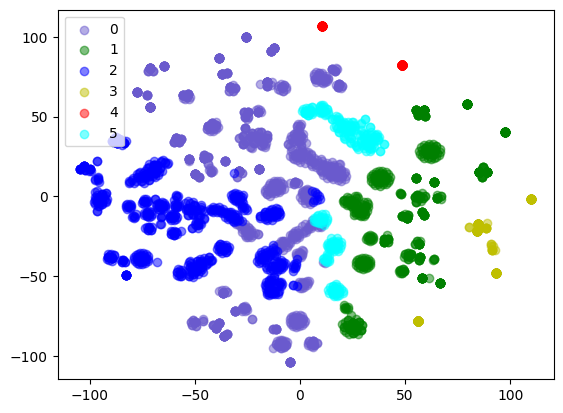

In [26]:
colors = ['#6A5ACD', 'g', 'b', 'y', 'r', 'cyan']  # 红色、绿色、蓝色、金色、矢车菊蓝、热情的粉红
ax = plt.subplot()
for i in range(num_clusters):
    ax.scatter(low_dim_vectors[np.where(df["cluster"] == i)[0], 0], 
            low_dim_vectors[np.where(df["cluster"] == i)[0], 1],
            c=colors[i], alpha=0.5, label=str(i))
plt.legend()

In [33]:
for i in cluster_indices[4]:
    print(tokenizer.decode(dataset[int(i)]["input_ids"][1497:]))

 
Human: 赶紧走。
Assistant: Action: go_away
Action Input: null<|endoftext|>
 
Human: 开始模仿我的动作
Assistant: no corresponding tools.<|endoftext|>
 
Human: Upgrade operation ongoing
Assistant: no corresponding tools.<|endoftext|>
 
Human: 别阻挡。
Assistant: Action: go_away
Action Input: null<|endoftext|>
 
Human: Evacuate the premises.
Assistant: Action: go_away
Action Input: null<|endoftext|>
 
Human: 去别处等。
Assistant: Action: go_away
Action Input: null<|endoftext|>
 
Human: user_defined_task:[]$$Power up operation
Assistant: no corresponding tools.<|endoftext|>
 
Human: user_defined_task:[Living Area Dust-off|Garage Organize]$$Activate Attic Overhaul
Assistant: no corresponding tools.<|endoftext|>
 
Human: user_defined_task:[午后休闲|深夜工作|日常维护]$$执行假日准备模式
Assistant: no corresponding tools.<|endoftext|>
 
Human: 别挡道。
Assistant: Action: go_away
Action Input: null<|endoftext|>
 
Human: 全力以赴
Assistant: no corresponding tools.<|endoftext|>
 
Human: Empty the space.
Assistant: Action: go_away
Action Input:

In [29]:
for i in cluster_indices[2]:
    print(tokenizer.decode(dataset[int(i)]["input_ids"][1497:]))

 
Human: Delete cleaning for the attic this weekend
Assistant: Action: schedule_operation
Action Input: {"operation_type": "delete", "location": "attic", "time": "this weekend"}<|endoftext|>
 
Human: 照顾到餐厅下方的清理工作。
Assistant: Action: clean
Action Input: {"action": "start", "location": "餐厅下方", "tool": "vacuum and mop"}<|endoftext|>
 
Human: Can you clean the children's room?
Assistant: Action: clean
Action Input: {"action": "start", "location": "children's room", "tool": "vacuum and mop"}<|endoftext|>
 
Human: Check the tasks for cleaning the guesthouse next weekend.
Assistant: Action: schedule_operation
Action Input: {"operation_type": "query", "location": "guesthouse", "time": "next weekend"}<|endoftext|>
 
Human: 在客厅进行抹洗。
Assistant: Action: clean
Action Input: {"action": "start", "location": "客厅", "tool": "mop only/拖/擦"}<|endoftext|>
 
Human: Move between the coffee table and armchair in the living room.
Assistant: Action: move
Action Input: {"location": "between the coffee table and 

In [30]:
for i in cluster_indices[3]:
    print(tokenizer.decode(dataset[int(i)]["input_ids"][1497:]))

 
Human: 建图流程中止一会。
Assistant: Action: mapping
Action Input: {"action": "pause"}<|endoftext|>
 
Human: 启动制图模块。
Assistant: Action: mapping
Action Input: {"action": "start"}<|endoftext|>
 
Human: Mapping journey begins.
Assistant: Action: mapping
Action Input: {"action": "start"}<|endoftext|>
 
Human: Processing firmware upgrade request
Assistant: Action: upgrade_firmware
Action Input: null<|endoftext|>
 
Human: Pause the cleaning.
Assistant: Action: clean
Action Input: {"action": "pause"}<|endoftext|>
 
Human: 打开地图创建功能。
Assistant: Action: mapping
Action Input: {"action": "start"}<|endoftext|>
 
Human: 暂缓地图工作。
Assistant: Action: mapping
Action Input: {"action": "pause"}<|endoftext|>
 
Human: Firmware update in progress
Assistant: Action: upgrade_firmware
Action Input: null<|endoftext|>
 
Human: Begin firmware upgrade task
Assistant: Action: upgrade_firmware
Action Input: null<|endoftext|>
 
Human: Update firmware version
Assistant: Action: upgrade_firmware
Action Input: null<|endoftext|>


In [34]:
df.to_csv("../outputs/roborock_control_lora_output_Yi_merged.csv", index=None)

In [36]:
joblib.dump(marginal_embeddings, "../outputs/roborock_control_lora_output_Yi_merged_emb.json")

['../outputs/roborock_control_lora_output_Yi_merged_emb.json']

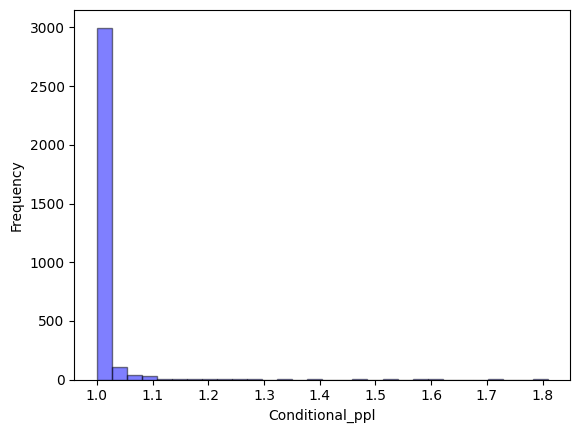

In [37]:
# Create histogram
plt.hist(df["conditional_ppl"], bins=30, alpha=0.5, color='blue', edgecolor='black')
# Add titles and labels
plt.xlabel('Conditional_ppl')
plt.ylabel('Frequency')
# Show plot
plt.show()

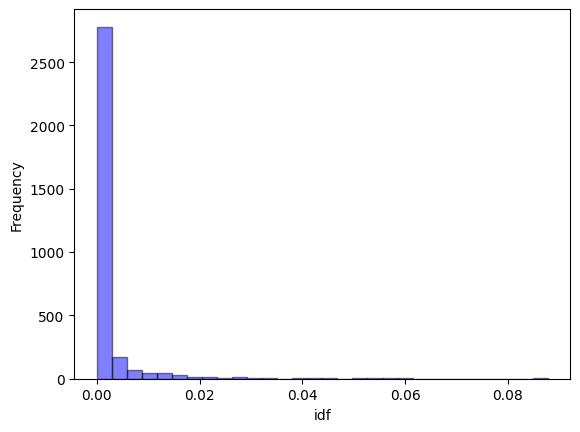

In [38]:
# Create histogram
plt.hist(df["idf"], bins=30, alpha=0.5, color='blue', edgecolor='black')
# Add titles and labels
plt.xlabel('idf')
plt.ylabel('Frequency')
# Show plot
plt.show()

In [41]:
dataset = dataset.add_column("conditional_ppl", df["conditional_ppl"].values)
dataset = dataset.add_column("marginal_ppl", df["marginal_ppl"].values)
dataset = dataset.add_column("idf", df["idf"].values)
dataset = dataset.add_column("idf_class", df["idf_class"].values)
dataset = dataset.add_column("conditional_ppl_class", df["conditional_ppl_class"].values)
dataset = dataset.add_column("cluster", df["cluster"].values)
dataset = dataset.add_column("idx", range(df.shape[0]))

In [46]:
# 定义筛选函数
def filter_samples_by_threshold(example):
    # 假设我们根据'sentence1'字段的长度来进行筛选
    return example['idf_class'] == "midd"

# 使用filter方法应用筛选函数
filtered_dataset = dataset.filter(filter_samples_by_threshold)

Filter:   0%|          | 0/3232 [00:00<?, ? examples/s]

In [52]:
filtered_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'conditional_ppl', 'marginal_ppl', 'idf', 'idf_class', 'conditional_ppl_class', 'cluster', 'idx'],
    num_rows: 1616
})

In [53]:
# 打开并读取JSON文件
with open("../data/ToolAlpaca/data/formatted_data/robocontrol_dataset_sharegpt.json", 'r') as file:
    data = json.load(file)

In [54]:
filtered_data = []
for i in range(len(filtered_dataset)):
    filtered_data.append(data[filtered_dataset[i]['idx']])

In [55]:
len(filtered_data)

1616

In [60]:
tokenizer.decode(filtered_dataset[33]["input_ids"])

' You have access to the following tools:\n> Tool Name: general_control\nTool Description: This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task\nTool Args:\n  - action (string, required): , should be one of [start, stop, pause, resume]\n  - user_defined_task (string): user-defined task described in user request\n\n> Tool Name: clean\nTool Description: Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.\nTool Args:\n  - action (string, required): , should be one of [start, stop, pause, resume]\n  - location (string): Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location.\n  - tool (string, required): \'vacuum and mop\' means vacuum and mop the floor at the same time, \'vacuum only\' is only v

In [57]:
print(filtered_data[33])

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [61]:
# 目标文件路径
file_path = '../data/ToolAlpaca/data/formatted_data/robocontrol_dataset_high_ppl_sharegpt.json'

# 打开文件并保存JSON数据
with open(file_path, 'w') as file:
    json.dump(filtered_data, file, indent=4)